## One Shot Learning with Siamese Networks

Before we do anything else we need to get our data files ready. Firstly we want to get the zipped data.

Do this by retrieving images_background.zip and images_evaluation.zip from the Python folder in [this](https://github.com/brendenlake/omniglot) GitHub repository. You can either clone the whole repository, or navigate to the repository and download the files directly. Notice that this repository falls under the following [license](https://github.com/brendenlake/omniglot/blob/master/LICENSE).

If you are using Colab, you will need to place these two zip files in a folder called 'omniglot' on your google drive rather than downloading them to your local computer. Otherwise download them to your computer.

Now we need to unzip these files. If you are using your local computer, unzip them to a suitable location of your choice.

*If you are using Colab* you will need to run the following two code blocks. These will:
1. Mount your google drive in Colab. Enter the following and complete the required authorizations.
2. Unzip the images into images_background and images_evaluation subfolders.

Note that you will need to mount your drive every time you use code from this tutorial. But you will only need to unzip the files in google drive once.

In [0]:
# ONLY RUN THIS CODE IF YOU ARE USING GOOGLE COLAB
# Note: You will need to mount your drive every time you 
# run code in this tutorial.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ONLY RUN THIS CODE IF:
# 1. YOU ARE USING GOOGLE COLAB
# 2. YOU HAVE NOT ALREADY UNZIPPED THE FILES PREVIOUSLY                  
!unzip -uq "/content/drive/My Drive/omniglot/images_background.zip" -d "/content/drive/My Drive/omniglot/"
!unzip -uq "/content/drive/My Drive/omniglot/images_evaluation.zip" -d "/content/drive/My Drive/omniglot/"

We import the modules we will use.

In [0]:
# importing keras modules
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Conv2D, Input
from keras import backend as K
from keras.regularizers import l2
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense

# importing other modules
import time
import numpy as np
from sklearn.utils import shuffle
from imageio import imread
import numpy.random as rng
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


Let's create a helper function to load the images from whereever we have placed them.

In [0]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

Now we can load the images. If you are running this on your computer, you will need to specify the folders you have placed the alphabet data in. Edit the code below so that the train_folder and eval_folder paths point to the appropriate folders.

*If you are running this on google Colab use the paths given below.*

In [0]:
train_folder="/content/drive/My Drive/omniglot/images_background/"
eval_folder="/content/drive/My Drive/omniglot/images_evaluation/"
images_train,classes_train,lang_dict_train = loadimgs(train_folder)
images_eval,classes_eval,lang_dict_eval = loadimgs(eval_folder)

loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Japanese_(hiragana)
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Burmese_(Myanmar)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Tagalog
loading alphabet: Tifinagh
loa

You can play around to get an idea of the data we are working with...

In [0]:
print(images_train.shape)
print(images_eval.shape)

print(classes_train.shape)
print(classes_train)

(964, 20, 105, 105)
(659, 20, 105, 105)
(19280, 1)
[[  0]
 [  0]
 [  0]
 ...
 [963]
 [963]
 [963]]


Let's create a function to allow us to plot the images we are working with. Then we can plot a random character.

In [0]:
def plot_images(ch_num,images):
    """
        Plot all 20 samples of a particular character
    """
    f, axarr = plt.subplots(5,4, figsize=(10,10))
    images_list = images[ch_num,:,:,:]
    for i in range(5):
        for j in range(4):
            axarr[i,j].imshow(images_list[i*4+j,:,:])

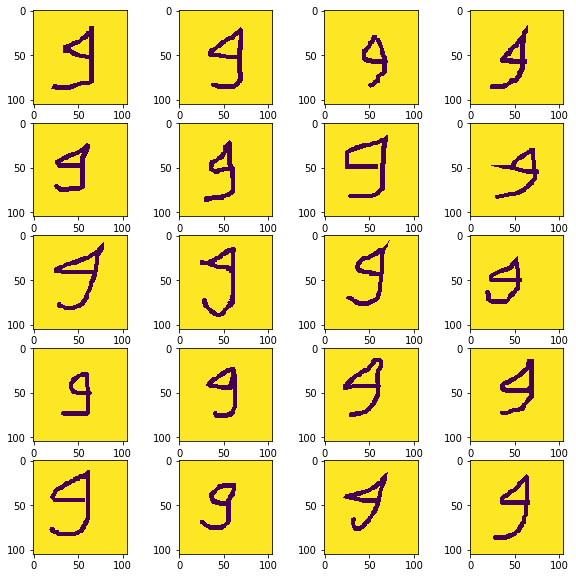

In [0]:
# Plot a random character. Change the number to plot a different one.
plot_images(254,images_train)

Since we want to learn to classify two random images as belonging to the same class or not, training batches will *not* simply be random samples from the training data with their associated labels. 
Instead a training batch will consist of n pairs, half of the pairs consisting of (different images of) the same character, half consisting of images of different characters. The labels will be 1 for matching pairs and 0 for non-matching pairs.
So we need a function that will generate such a training batch from the training data. 
We will also create a function that allows us to plot a training batch of images, and use it to see what a batch looks like.

In [0]:
def get_batch(batch_size,images):
    """
    Create batch of n pairs, half same class, half different class
    """
    n_classes, n_examples, w, h = images.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = images[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to 
            # ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = images[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

def plot_batch(batch_pairs):
    """
        Plot all pairs of a particular batch
    """
    f, axarr = plt.subplots(batch_pairs[0].shape[0],2, figsize=(100,100))
    for i in range(batch_pairs[0].shape[0]):
        for j in range(2):
            axarr[i,j].imshow(batch_pairs[j][i,:,:,0])

Now we will have a look at a randomöy generated batch. You may need to scroll horizontally to see the second image in each pair.

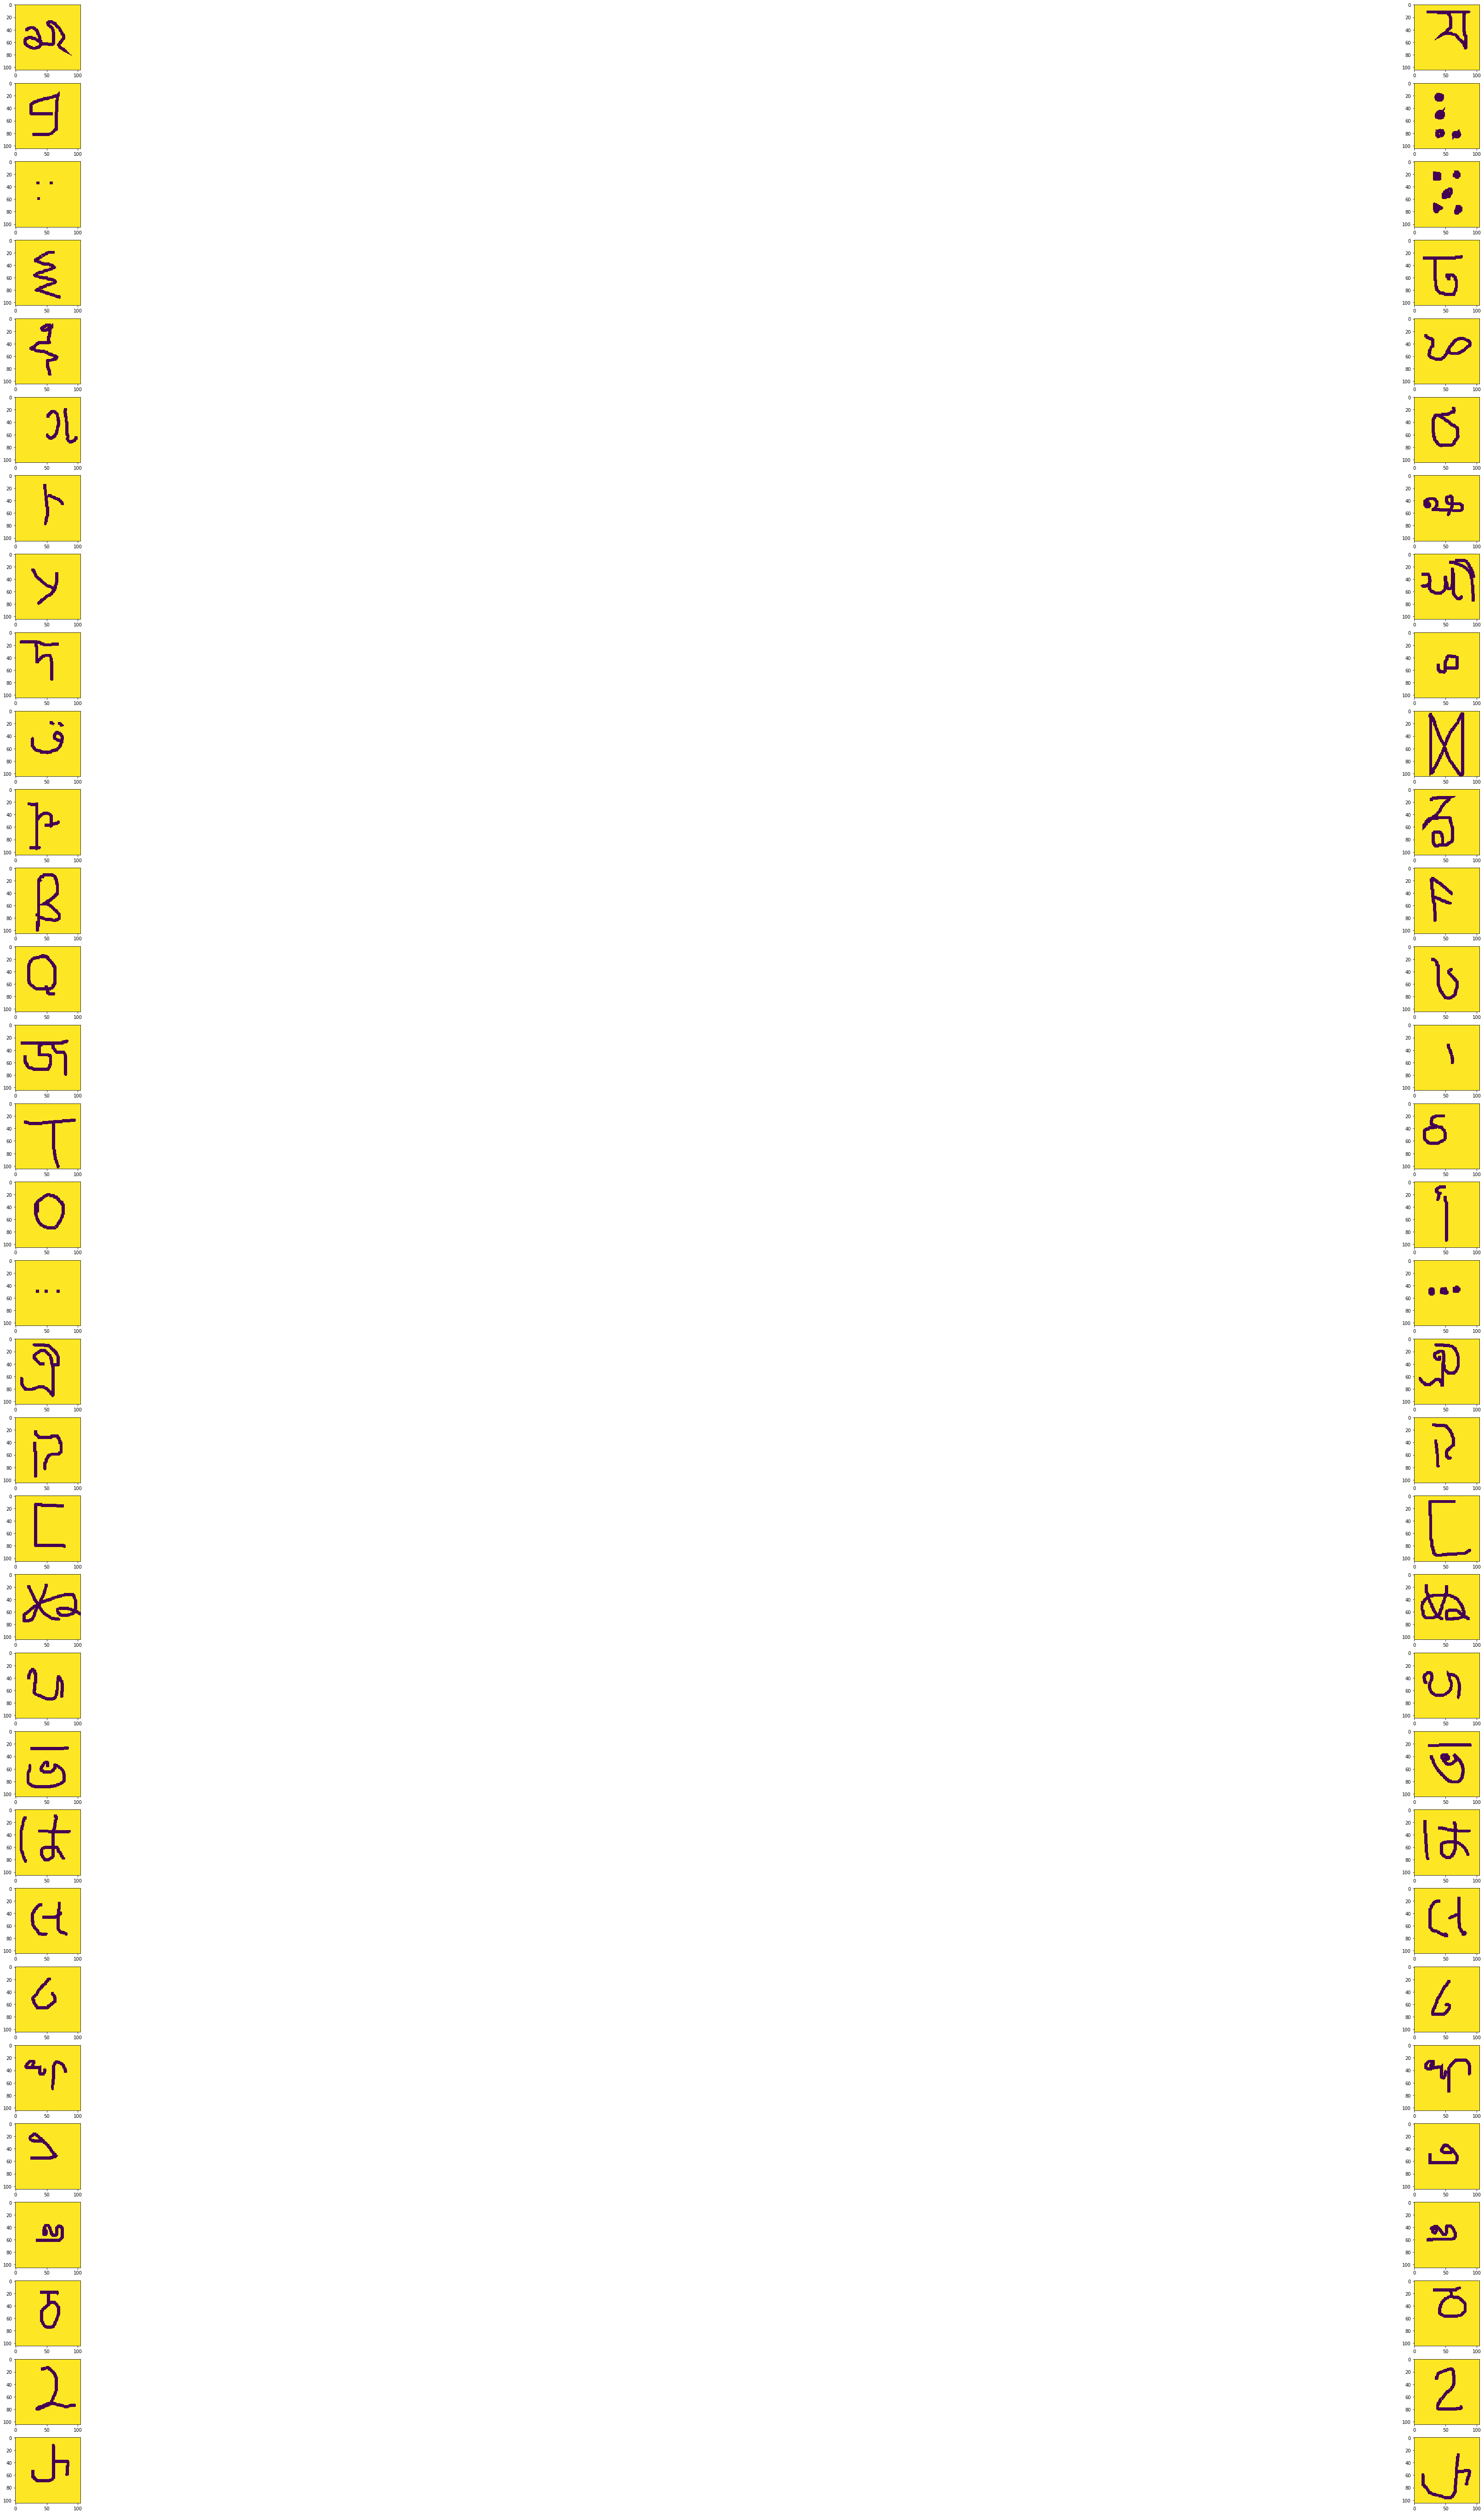

In [0]:
# Let's look at a random training batch
batch_pairs,batch_targets=get_batch(32,images_train)
plot_batch(batch_pairs)

Though we will not do so, a function like the above that creates a batch can be used with a generator function for training. Below is an example of such a generator function. If you are unfamiliar with generators and the yield keyword, read all about it [here](https://pythontips.com/2013/09/29/the-python-yield-keyword-explained/).

In [0]:
def generate(batch_size, s="train"):
    """
    a generator for batches, so model.fit_generator can be used.
    """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

Now lets define the model. We will create three functions:
1. A function that will define a Siamese network from any base model and input shape.
2. A function that will define the base CNN model we want to use for this task.
3. A helper function that will call the two above functions to produce the Siamese network we want to use in this task.

In [0]:
def get_siamese_model(model, input_shape):
    """
        Siamese network architecture created from passed base model
    """    
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

def get_base_cnn_model(input_shape):
    """
        Base CNN model architecture
    """    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, 
                     (10,10), 
                     activation='relu', 
                     input_shape=input_shape,
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 
                     (7,7), 
                     activation='relu',
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 
                     (4,4), 
                     activation='relu', 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, 
                     (4,4), 
                     activation='relu', 
                     kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, 
                    activation='sigmoid',
                    kernel_regularizer=l2(1e-3)))
    
    return model

def get_siamese_cnn_model (input_shape):    
    cnn_model=get_base_cnn_model(input_shape)
    siamese_model=get_siamese_model(cnn_model, input_shape)
    return siamese_model

Now let's create and compile the model we will. We have to define an optimizer for this, and I've just specified a simple Adam optimizer. Feel free to try others.

In [0]:
# Let's create and compile the model with an optimizer
model=get_siamese_cnn_model((images_train.shape[2],images_train.shape[3],1))
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We have what we need to train the network, but not what we want to evaluate its performance on validation and test data. For this we would like to set up a means of performing one-shot matching, where the network has to identify the matching character to a specified character from n possible images. We do this now by defining two functions.

In [0]:
def make_oneshot_task(N, images):
    """
    Create pairs of test image, support set for testing N way one-shot learning. 
    """
    n_classes, n_examples, w, h = images.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    
    categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([images[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    
    support_set = images[categories,indices,:,:]
    support_set[0,:,:] = images[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)

    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]
    return pairs, targets
  
def test_oneshot(model, N, k, images, verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,images)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

Now we are really ready for training. We will manually define a training loop utilizing Keras' train_on_batch functionality. Periodically we will examine how well our model performs on the one-shot task on validation data. 

In [0]:
def train_model(
    model,
    images_train,
    images_eval,
    evaluate_every = 10, # interval for evaluating on one-shot tasks
    loss_every = 20, # interval for printing loss (iterations)
    batch_size = 32,
    n_iter = 20000,
    N_way = 20, # how many classes for testing one-shot tasks>
    n_val = 250, # how many one-shot tasks to validate on?
    best = -1,
    model_path="/content/drive/My Drive/omniglot/"
):
    print("Starting training process!")
    print("-------------------------------------")
    weights_path = os.path.join(model_path, "model_weights.h5")
    
    t_start = time.time()
    for i in range(1, n_iter):
        (inputs,targets)=get_batch(batch_size,images_train)
        loss=model.train_on_batch(inputs,targets)
        print("\n ------------- \n")
        print("Loss: {0}".format(loss)) 
        if i % evaluate_every == 0:
            print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
            val_acc = test_oneshot(model,N_way,n_val,images_eval,verbose=True)
            if val_acc >= best:
                print("Current best: {0}, previous best: {1}".format(val_acc, best))
                print("Saving weights to: {0} \n".format(weights_path))
                model.save_weights(weights_path)
                best=val_acc

        if i % loss_every == 0:
            print("iteration {}, training loss: {:.2f},".format(i,loss))

    model.load_weights(weights_path)
    return model

Now let's train the model :)

In [0]:
model=train_model(model,images_train,images_eval)

Starting training process!
-------------------------------------

 ------------- 

Loss: 6.180230140686035

 ------------- 

Loss: 6.1412434577941895

 ------------- 

Loss: 6.135758876800537

 ------------- 

Loss: 6.102414608001709

 ------------- 

Loss: 6.081302165985107

 ------------- 

Loss: 6.059758186340332

 ------------- 

Loss: 6.022852897644043

 ------------- 

Loss: 5.982556343078613

 ------------- 

Loss: 5.973055362701416

 ------------- 

Loss: 5.938838958740234
Time for 10 iterations: 91.22019457817078
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 8.0% 20 way one-shot learning accuracy 

Current best: 8.0, previous best: -1
Saving weights to: /content/drive/My Drive/omniglot/model_weights.h5 


 ------------- 

Loss: 5.911966323852539

 ------------- 

Loss: 5.889459133148193

 ------------- 

Loss: 5.8596696853637695

 ------------- 

Loss: 5.828066825866699

 ------------- 

Loss: 5.807260036468506

 ------------- 

Loss: 5.

Note that the final weights from training will be automatically saved in the specified directory in the file "model_weights.h5", so you can recreate the network and load these weights.